### Long Short-Term Memory (LSTM) Network to predict average annual Sun Black Spots between 1700 & 1920

**Long short-term memory (LSTM)** units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM).

In this notebook the **keras** library is used to implement the LSTM network.

The data will be used as follow:
* 1712-1920: training set
* 1921-1955: validation set
* 1956-1979: test set

The goal is to predict the annual average sun black spots using the $12$ previous data points.

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from seaborn import scatterplot
import pandas as pd
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import variation
from keras import regularizers
from keras.layers.core import Dropout

In [96]:
df = pd.read_csv('C:/../Sunspots.csv', header = None)

In [97]:
df.head()

,0,1
0,1700,0.0262
1,1701,0.0575
2,1702,0.0837
3,1703,0.1203
4,1704,0.1883


In [98]:
# fix random seed for reproducibility
np.random.seed(7)

Extract the data column.

In [99]:
years = df.loc[:,0]
df = df.drop(0,axis=1)

#### Visualization

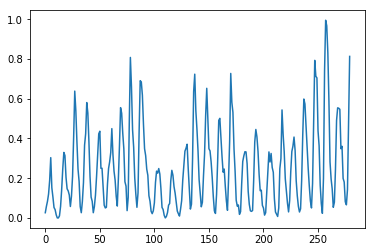

In [100]:
# plot baseline
plt.plot(df)

### Coefficient of Variation (CV) of Test Data

The **coefficient of variation (CV)**, also known as **relative standard deviation (RSD)**, is a standardized measure of dispersion of a probability distribution or frequency distribution. It is often expressed as a percentage, and is defined as the ratio of the standard deviation $\sigma$ to the mean $\mu$.

CV of the test observations will be used to compare the CV for the predictions to see how close they are.

In [101]:
print('Coefficient of Variation(CV) or Relative Standard Deviation(RSD) of base data', variation(df[256:280]))
dfx = pd.DataFrame(df[256:280])
dfx.describe()

Coefficient of Variation(CV) or Relative Standard Deviation(RSD) of base data [0.69712238]


,1
count,24.000000
mean,0.414171
std,0.294938
min,0.053400
25%,0.171775
50%,0.354300
75%,0.562250
max,0.994700


Normalize the data using the *MinMaxScaler* to give values between $0$ & $1$.

In [102]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

Extract training, validation and test sets.

In [103]:
# split into train and test sets
train,validation,test = dataset[0:221], dataset[221:256],dataset[256:280]
print(len(train),len(validation), len(test))

221 35 24


The following function converts the input array into a dataset with dataX being values at time step (t) and dataY values at time step (t+1). This is necessary since LSTM predicts a value based the previous value.

look_back is the number of previous time steps to use as input variables to predict the next time period (here defaulted to $1$).

However, since we will be looking at $12$ previous data points, when *look_back* is set to $12$, this function will create rows $13$ data points at a time with the last $12$ points of current row being passed onto the next row and $13^{th}$ data point being a new point and so on.

This way for each new point, positioned at the last column to represent the target variable, we will be able to take into consideration the $12$ previous points which constitute the predictors.

The function returns both the predictors and the target variable.

In [104]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In what follows the train and validation sets are created using the above function. These are then reshaped into a structure expected by LSTM. The model is then created and fitted to the data and predictions are subsequently made.

After playing around with the parameters, the optimal value for the number of hidden neurons was found to be $8$ and the best optimizer *adam*.

In [105]:
# reshape into X=t and Y=t+1
look_back = 12
trainX, trainY = create_dataset(train, look_back)
validationX, validationY = create_dataset(validation, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validationX = np.reshape(validationX, (validationX.shape[0], 1, validationX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2, validation_data = (validationX, validationY))

Train on 208 samples, validate on 22 samples
Epoch 1/50
 - 7s - loss: 0.0474 - val_loss: 0.0544
Epoch 2/50
 - 2s - loss: 0.0212 - val_loss: 0.0309
Epoch 3/50
 - 2s - loss: 0.0145 - val_loss: 0.0183
Epoch 4/50
 - 2s - loss: 0.0123 - val_loss: 0.0186
Epoch 5/50
 - 2s - loss: 0.0110 - val_loss: 0.0121
Epoch 6/50
 - 2s - loss: 0.0104 - val_loss: 0.0153
Epoch 7/50
 - 2s - loss: 0.0096 - val_loss: 0.0118
Epoch 8/50
 - 2s - loss: 0.0091 - val_loss: 0.0161
Epoch 9/50
 - 2s - loss: 0.0087 - val_loss: 0.0111
Epoch 10/50
 - 2s - loss: 0.0082 - val_loss: 0.0130
Epoch 11/50
 - 2s - loss: 0.0081 - val_loss: 0.0084
Epoch 12/50
 - 2s - loss: 0.0075 - val_loss: 0.0077
Epoch 13/50
 - 2s - loss: 0.0070 - val_loss: 0.0097
Epoch 14/50
 - 2s - loss: 0.0070 - val_loss: 0.0066
Epoch 15/50
 - 2s - loss: 0.0070 - val_loss: 0.0081
Epoch 16/50
 - 2s - loss: 0.0065 - val_loss: 0.0077
Epoch 17/50
 - 2s - loss: 0.0064 - val_loss: 0.0070
Epoch 18/50
 - 2s - loss: 0.0062 - val_loss: 0.0073
Epoch 19/50
 - 2s - loss: 0.

Then we make the predictions for training an validation sets purely for visual demonstration that the model of course performs well on data it has already seen.

Next, these predictions are scaler inverted to prepare them for plotting in the next stage.

In [117]:
# make predictions
trainPredict = model.predict(trainX)
validationPredict = model.predict(validationX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
validationPredict = scaler.inverse_transform(validationPredict)
validationY = scaler.inverse_transform([validationY])

## Visualization of Prediction of Training and Evaluation Sets

The generated dataset is in blue, prediction corresponding to training data is in orange and prediction corresponding to validation set is in green.

It can be seen that the model does well. But this on data it has seen and the real performance evaluation comes from predicting the remaining time series without training on the test set.

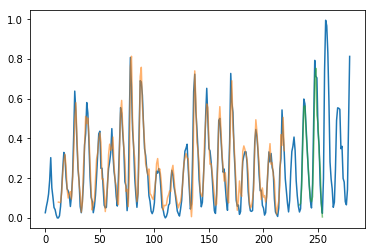

In [119]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift validation predictions for plotting
validationPredictPlot = np.empty_like(dataset)
validationPredictPlot[:, :] = np.nan
validationPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+len(validationPredict)+(look_back*2)+1, :] = validationPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, alpha = 0.6)
plt.plot(validationPredictPlot, alpha = 0.6)

plt.show()

## Prediction of Unseen Data

Predict_test function returns the predictions for data points equivalent to the length of the test set without ever having seen them.

In [120]:
def Predict_test(dataset, look_back=1):
    index = 256
    dummy = []
    setD = dataset[index-look_back:index,0]
    setT = setD
    dummy.append(setD)
    setX = np.array(dummy)
    setX = np.reshape(setX, (setX.shape[0], 1, setX.shape[1]))

    for i in range(0,len(test)):
        dummy = []
        pred = model.predict(setX)
        setT = np.append(setT,(pred[:,0][0]))
        setD = dataset[(index-look_back)+i:index+i,0]
        dummy.append(setD)
        setX = np.array(dummy)
        setX = np.reshape(setX, (setX.shape[0], 1, setX.shape[1]))
    
    return setT

#### Predictions and analysis

It can be seen that the model perdorms well.

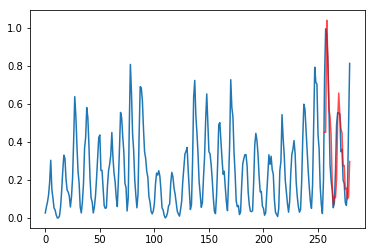

In [134]:
look_back = 12

setT = Predict_test(dataset, look_back)
setT = np.reshape(setT, (setT.shape[0], 1))
setT = scaler.inverse_transform(setT)
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[256:] = setT[12:]
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot, color = 'red', alpha = 0.7)

One way to evaluate the predicition performance is to look at the **Root-Mean-Squared Errors (RMSE)** between the training data and their predictions and compare that to the **(RMSE)** of the test data and it's prediction.

Given the small difference between these 2 values, it can be concluded that the predictions have a high accuracy or rather the resultant predicted time series data is a good representation of the original test data.

In [141]:
trainScore = math.sqrt(mean_squared_error(train[13:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(test[:], setT[12:]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.14 RMSE
Test Score: 0.21 RMSE


Another way to confirm this is by looking at the coefficient of variation.

Comparing the following CV from the original data and the one for the predicted data:

* Coefficient of Variation(CV) or Relative Standard Deviation(RSD) [0.69712238]

The small difference means that the accuracy of the prediction is high.

In [142]:
print('Coefficient of Variation(CV) or Relative Standard Deviation(RSD) of test data', variation(setT[:,0]))

Coefficient of Variation(CV) or Relative Standard Deviation(RSD) of test data 0.6902632704718394


However, the following shows that model is overfitting since the validation curve keeps diving across the training curve and back up.

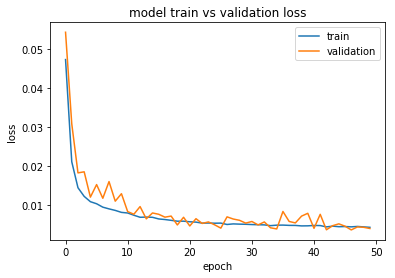

In [143]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#this kind of plot means it is over-fitting

So in the next section regularization is introduced in the attempt to fix this.

### LSTM with regularization

There are a number of regularization techniques that can be applied.

For example:
* dropout: where weights or neurons are dropped one at a time at each iteration
* L1 penalty
* L2 penalty
* Data augmentation

The LI and L2 penalties can be imposed one at a time or together and they can be applied to the following:
* bias
* weights
* inputs

After experimentation with all of the above (except data augmentation), only bias L2 regularization showed promise. The coefficient of variance for this model is quite equal to the baseline CV of the previous model.

Furthermore, the best number of neurons turned out to be $9$ and the a minimum of $100$ epochs is required to obtain these results.

In [144]:
# reshape into X=t and Y=t+1
look_back = 12
trainX, trainY = create_dataset(train, look_back)
validationX, validationY = create_dataset(validation, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validationX = np.reshape(validationX, (validationX.shape[0], 1, validationX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(9, input_shape=(1, look_back)))
model.add(Dense(1, bias_regularizer=regularizers.L1L2(l1=0.0, l2=0.01)))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, validation_data = (validationX, validationY))

# make predictions
trainPredict = model.predict(trainX)
validationPredict = model.predict(validationX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validationPredict = scaler.inverse_transform(validationPredict)
validationY = scaler.inverse_transform([validationY])

Train on 208 samples, validate on 22 samples
Epoch 1/100
 - 8s - loss: 0.0371 - val_loss: 0.0380
Epoch 2/100
 - 2s - loss: 0.0175 - val_loss: 0.0218
Epoch 3/100
 - 2s - loss: 0.0132 - val_loss: 0.0128
Epoch 4/100
 - 2s - loss: 0.0119 - val_loss: 0.0098
Epoch 5/100
 - 2s - loss: 0.0109 - val_loss: 0.0112
Epoch 6/100
 - 2s - loss: 0.0103 - val_loss: 0.0109
Epoch 7/100
 - 2s - loss: 0.0095 - val_loss: 0.0094
Epoch 8/100
 - 2s - loss: 0.0091 - val_loss: 0.0070
Epoch 9/100
 - 2s - loss: 0.0083 - val_loss: 0.0108
Epoch 10/100
 - 2s - loss: 0.0082 - val_loss: 0.0106
Epoch 11/100
 - 2s - loss: 0.0079 - val_loss: 0.0070
Epoch 12/100
 - 2s - loss: 0.0074 - val_loss: 0.0073
Epoch 13/100
 - 2s - loss: 0.0073 - val_loss: 0.0075
Epoch 14/100
 - 2s - loss: 0.0070 - val_loss: 0.0062
Epoch 15/100
 - 2s - loss: 0.0068 - val_loss: 0.0062
Epoch 16/100
 - 2s - loss: 0.0067 - val_loss: 0.0079
Epoch 17/100
 - 2s - loss: 0.0064 - val_loss: 0.0086
Epoch 18/100
 - 2s - loss: 0.0064 - val_loss: 0.0064
Epoch 19/1

The effects of the L2-norm bias regularization are detectable in the plot below. The model is not over-fitting as much as before.

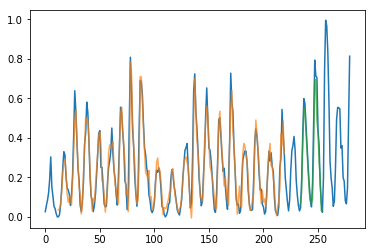

In [147]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift validation predictions for plotting
validationPredictPlot = np.empty_like(dataset)
validationPredictPlot[:, :] = np.nan
validationPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+len(validationPredict)+(look_back*2)+1, :] = validationPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, alpha = 0.7)
plt.plot(validationPredictPlot,  alpha = 0.7)
plt.show()

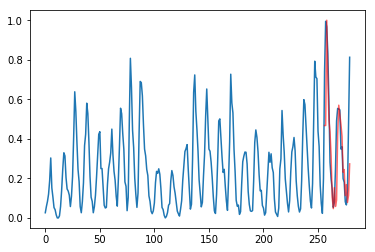

In [148]:
look_back = 12

setT = Predict_test(dataset, look_back)
setT = np.reshape(setT, (setT.shape[0], 1))
setT = scaler.inverse_transform(setT)
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[256:] = setT[12:]
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot, color = 'red', alpha = 0.6)

**Root-Mean-Squared Errors (RMSE)**

It seems that the model performs better without regularization since the difference between the 2 RMSEs is bigger than before. This is also apparent in the Coefficient of Variation difference in the next cell.

Perhaps regularization helps when a greater number of points need to be predicted.

In [150]:
trainScore = math.sqrt(mean_squared_error(train[13:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(test[:], setT[12:]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.13 RMSE
Test Score: 0.22 RMSE


Baseline coefficient of variation:

* Coefficient of Variation(CV) or Relative Standard Deviation(RSD) of base data [0.69712238]

Compare this to the result below.

In [151]:
print('Coefficient of Variation(CV) or Relative Standard Deviation(RSD) of test data', variation(setT[:,0]))

Coefficient of Variation(CV) or Relative Standard Deviation(RSD) of test data 0.7232373487255538


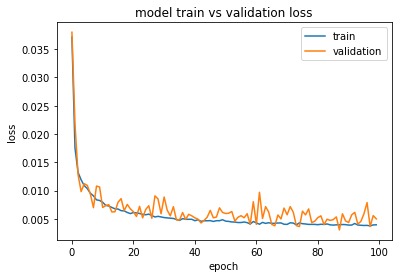

In [152]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#this kind of plot means it is over-fitting

The above visualization clearly shows that over-fitting persists if not worsens.